Szükséges könyvtárak betöltése

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import Delaunay
from scipy.spatial.qhull import QhullError
import math
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from plotly.subplots import make_subplots

Adatok beolvasása a számítógépről

In [2]:
#Időmérő a beolvasáshoz. Debug és teljesítménymérési célokra.
start_time = time.time()

#Az adatok elérhetőek az alábbi linken: https://github.com/CSSEGISandData/COVID-19
path = "./COVID-19/csse_covid_19_data/csse_covid_19_daily_reports"
covid_from_raw = pd.DataFrame()
files = [file for file in os.listdir(path) if ( (not (file.startswith('.') or file.startswith('R'))))] # Ignore hidden files and README

for file in files:
    
    #Beolvasás
    raw_data = pd.read_csv(path+"/"+file)
    current_data = pd.DataFrame()
    
    #Szükséges mezők elmentése
    current_data['Confirmed'] = raw_data['Confirmed']
    current_data['Deaths'] = raw_data['Deaths']
    
    #Dátum kinyerése a fájlnév alapján.  
    date = pd.to_datetime(file[:-4])
    current_data["Date"] = date.date()
    
    #Sémaváltozás kezelése.
    if date<pd.to_datetime("03-22-2020") :
        current_data['Country'] = raw_data['Country/Region']
    else :
        current_data['Country'] = raw_data['Country_Region']
        
    #Átírás az ideiglenes változóból abba, amivel később dolgozni fogunk.
    covid_from_raw = pd.concat([covid_from_raw, current_data])
   
#Művelet idejének kiírása
print("--- %s seconds ---" % (time.time() - start_time))

--- 22.33178162574768 seconds ---


Adattranszformációk

In [3]:
#Régiónként adatokat közlő országok adatainak összesítése
grouped_multiple = covid_from_raw.groupby(['Country', 'Date']).agg({'Confirmed': 'sum','Deaths': 'sum'})

#Új oszlopok a napi eseteknek
grouped_multiple.columns = ['all_Conf','all_Death']
grouped_multiple = grouped_multiple.reset_index()
covidbycont = {}
for cont in pd.unique(grouped_multiple['Country']):
    #Aktuális ország adatainak kiolvasása
    grcopy = grouped_multiple[grouped_multiple['Country']==cont].copy()
    dfcont = pd.DataFrame()
    dfcont['all_Conf'] = grcopy['all_Conf']
    dfcont['all_Death'] = grcopy['all_Death']
    dfcont['Date'] = grcopy['Date']
    
    #Napi adatok származtatása
    dfcont['Conf'] = dfcont['all_Conf'].diff()
    dfcont['Death'] = dfcont['all_Death'].diff()
    dfcont = dfcont.reset_index()
    #Első napi adatok kiegészítése. Ezekre a különbséget számoló függvény nem tudott értéket adni. 
    #Az első napra közölt összes esetszám az első napi esetszám, ez kerülide.
    dfcont.loc[0,'Conf'] =dfcont.loc[0,'all_Conf'] 
    dfcont.loc[0,'Death'] =dfcont.loc[0,'all_Death'] 
    #Beírás a szótárba az országnév mint kulcs szerint.
    
    dfcont['int_date'] = (dfcont['Date']-dfcont.loc[0,'Date']).apply(lambda x: x.days)
    scaler = MinMaxScaler()
    dfcont['Date_scaled'] = scaler.fit_transform(dfcont['int_date'].values.reshape(-1,1))
    #dfcont.drop(['int_date'],axis=1)
    covidbycont[cont]=dfcont


Segédfüggvények a minőségmetrika kiszámításához

In [4]:
#A három megadott csúcs alkotta háromszög kerületének kiszámításához
def peri(a,b,c):
    return (math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2) 
            + math.sqrt((a[0]-c[0])**2+(a[1]-c[1])**2) 
            + math.sqrt((c[0]-b[0])**2+(c[1]-b[1])**2))

#A három megadott csúcs alkotta háromszög területének kiszámításához
def area(a,b,c):
    return 0.5*abs(np.linalg.det(np.array([[a[0],b[0],c[0]],
                                          [a[1],b[1],c[1]],
                                          [1, 1, 1]])))

#Uncompactness 1 háromszögre
def uc1(a,b,c):
    return peri(a,b,c)/math.sqrt(area(a,b,c))

#Átlagos uncompactness számítása háromszögek tömbjére
def muc(hszk):
    akk=0
    for hsz in hszk:
        auc=uc1(hsz[0],hsz[1],hsz[2])
        akk+=auc
    return akk/hszk.shape[0]

# Képletek: https://www.analyzemath.com/Geometry_calculators/perimeter-and-area-of-triangle-given-vertices.html

Skálázási faktorok számítása országonként

In [5]:
ss = np.arange(0.1,5.1,0.1)
start_time = time.time()
sff = pd.DataFrame(columns = ['scale_f', 'Contry'])
#Az összes országra
for acont in covidbycont:
    #
    acontd = covidbycont[acont].copy()
    if acontd.shape[0]>=30:
        points = np.transpose(np.array([acontd['Conf'], acontd['Death']]))
        try:
            Delaunay(points)
        except (QhullError, NameError):
            continue
        tri = Delaunay(points)
        Lmuc = []
        for sf in ss:
            points2 = points.copy()
            points2[:,1] *= sf
            atri = Delaunay(points2)
            Lmuc.append(muc(points[atri.simplices]))
        sff = sff.append({'scale_f':ss[np.argmin(Lmuc)],'Contry':acont}, ignore_index = True)
print("--- %s seconds ---" % (time.time() - start_time))
#sff.head(15)

--- 153.88902115821838 seconds ---


In [7]:
ss = np.arange(0.1,5.1,0.1)
start_time = time.time()
sff2 = pd.DataFrame(columns = ['scale_f', 'Contry', 'LMUC', 'datacount'])
#Az összes országra
for acont in covidbycont:
    #
    acontd = covidbycont[acont].copy()
    if acontd.shape[0]>=30:
        points = np.transpose(np.array([acontd['Conf'], acontd['Death']]))
        try:
            Delaunay(points)
        except (QhullError, NameError):
            continue
        tri = Delaunay(points)
        Lmuc = []
        for sf in ss:
            points2 = points.copy()
            points2[:,1] *= sf
            atri = Delaunay(points2)
            Lmuc.append(muc(points[atri.simplices]))
        #print(acont + " "+ str(points.shape[0]))
        sff2 = sff2.append({'scale_f':ss[np.argmin(Lmuc)],'Contry':acont, 'LMUC':Lmuc.copy(), 'datacount':points.shape[0]}, ignore_index = True)
sff2['datacount']=sff2['datacount'].astype(int)
print("--- %s seconds ---" % (time.time() - start_time))


--- 145.5619761943817 seconds ---


In [31]:
sff.values

array([[1.0, 'Afghanistan'],
       [1.0, 'Albania'],
       [1.0, 'Algeria'],
       [0.9, 'Andorra'],
       [1.0, 'Angola'],
       [0.6, 'Antigua and Barbuda'],
       [1.0, 'Argentina'],
       [1.0, 'Armenia'],
       [1.0, 'Australia'],
       [1.0, 'Austria'],
       [1.0, 'Azerbaijan'],
       [1.0, 'Bahamas'],
       [1.0, 'Bahrain'],
       [1.0, 'Bangladesh'],
       [1.0, 'Barbados'],
       [0.9, 'Belarus'],
       [1.0, 'Belgium'],
       [1.0, 'Belize'],
       [0.8, 'Benin'],
       [0.30000000000000004, 'Bhutan'],
       [1.0, 'Bolivia'],
       [1.0, 'Bosnia and Herzegovina'],
       [0.2, 'Botswana'],
       [1.0, 'Brazil'],
       [0.1, 'Brunei'],
       [1.0, 'Bulgaria'],
       [0.9, 'Burkina Faso'],
       [1.0, 'Burma'],
       [4.3999999999999995, 'Burundi'],
       [0.9, 'Cabo Verde'],
       [0.30000000000000004, 'Cambodia'],
       [0.9, 'Cameroon'],
       [1.0, 'Canada'],
       [1.2000000000000002, 'Central African Republic'],
       [1.0, 'Chad'],
     

Others, count: 33


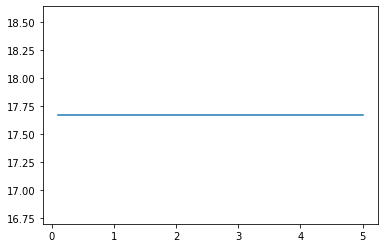

UK, count: 40


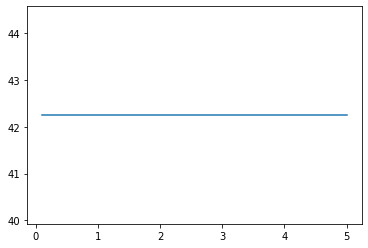

South Korea, count: 48


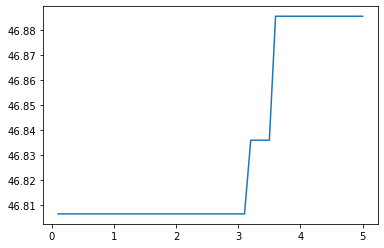

Taiwan, count: 48


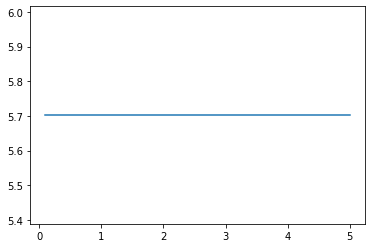

Hong Kong, count: 48


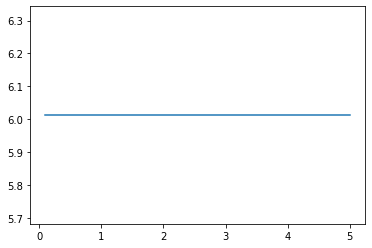

Mainland China, count: 51


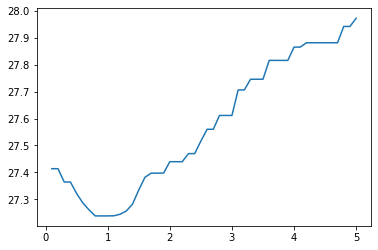

Lesotho, count: 308


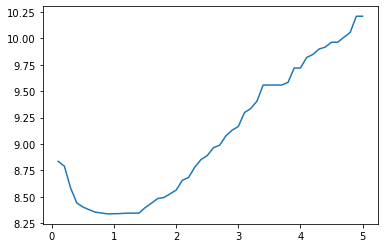

Comoros, count: 321


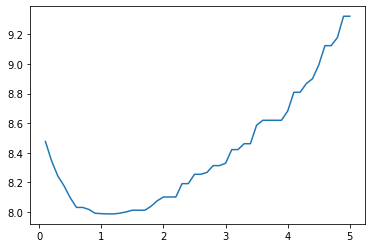

Tajikistan, count: 321


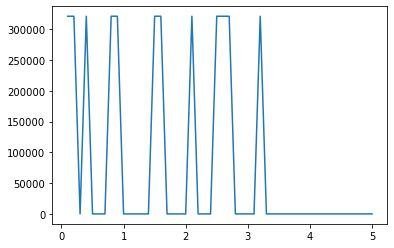

Yemen, count: 341


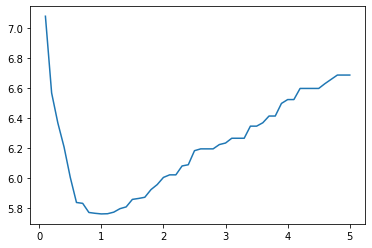

Sao Tome and Principe, count: 345


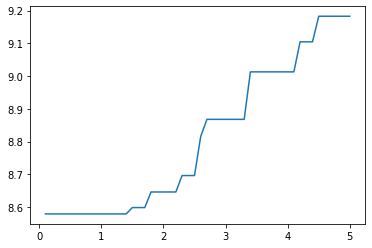

South Sudan, count: 346


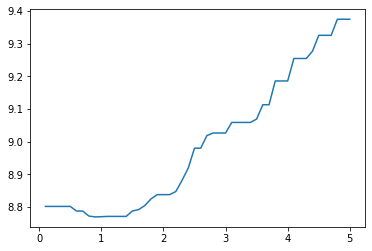

Malawi, count: 349


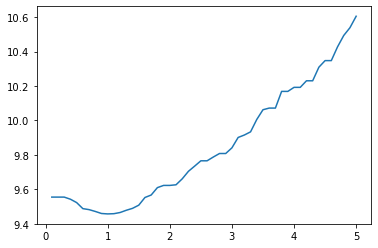

Sierra Leone, count: 351


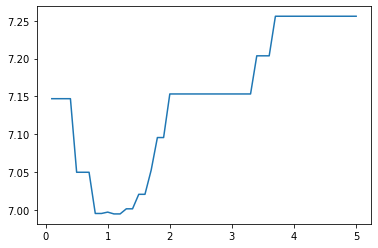

Burundi, count: 351


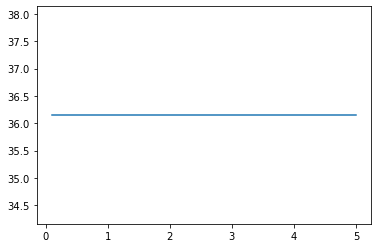

Botswana, count: 352


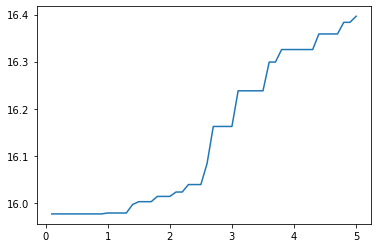

MS Zaandam, count: 354


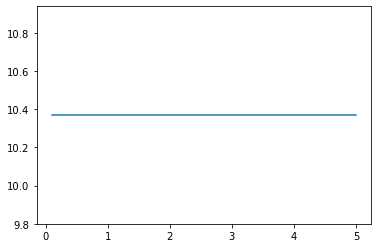

Burma, count: 355


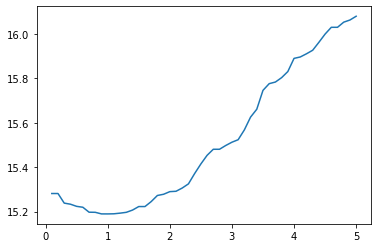

West Bank and Gaza, count: 356


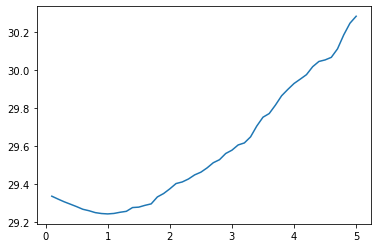

Guinea-Bissau, count: 357


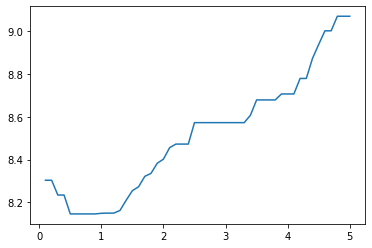

Mali, count: 357


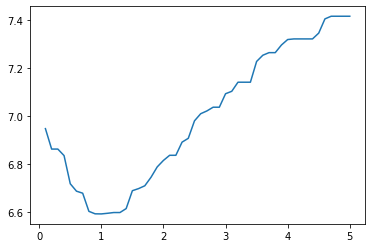

Diamond Princess, count: 357


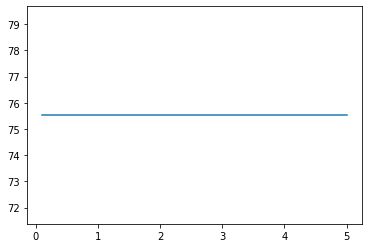

Libya, count: 358


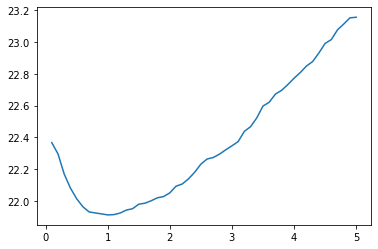

Belize, count: 359


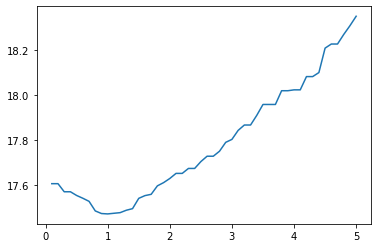

Syria, count: 360


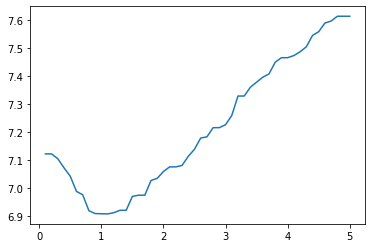

Gambia, count: 360


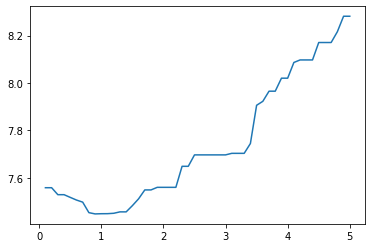

Bahamas, count: 360


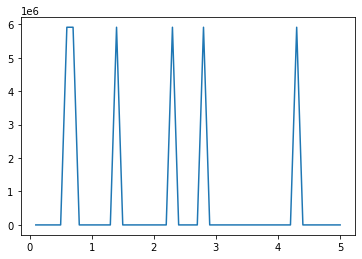

Grenada, count: 360


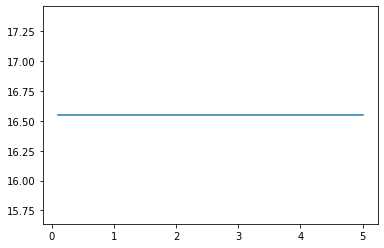

Mozambique, count: 360


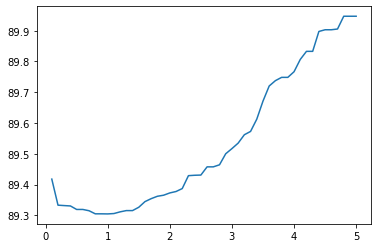

Uganda, count: 361


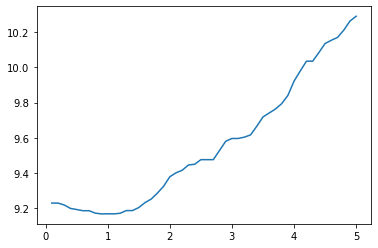

Eritrea, count: 361


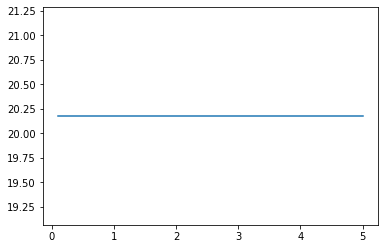

Papua New Guinea, count: 362


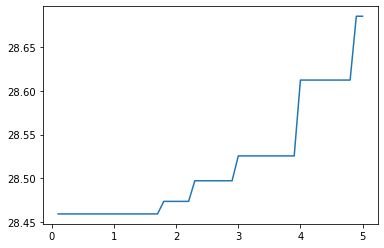

Cabo Verde, count: 362


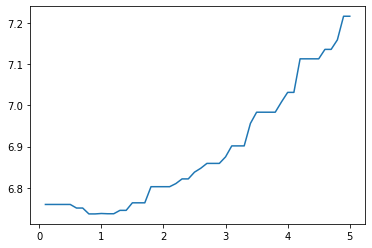

Madagascar, count: 362


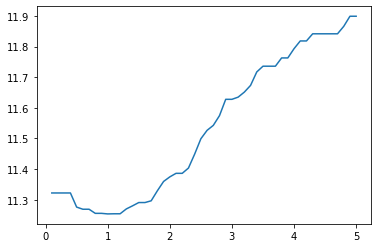

Haiti, count: 362


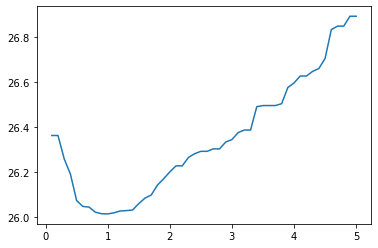

Angola, count: 362


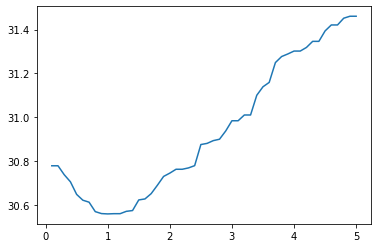

Niger, count: 362


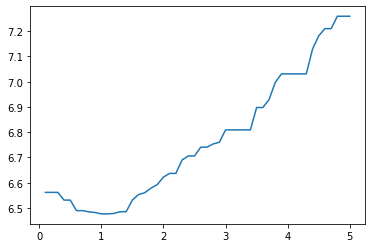

Zimbabwe, count: 362


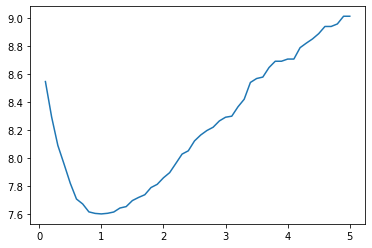

Fiji, count: 363


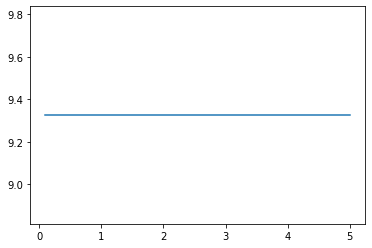

El Salvador, count: 363


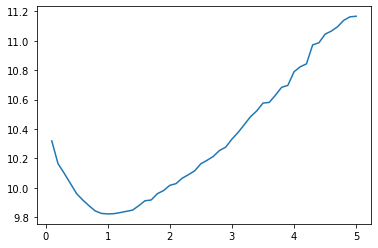

Kosovo, count: 363


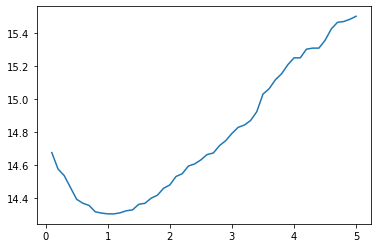

Nicaragua, count: 363


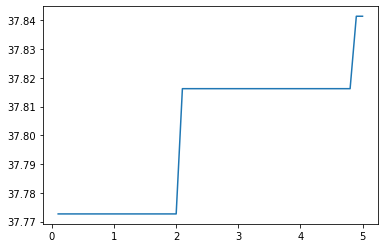

Chad, count: 363


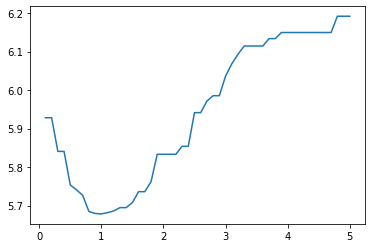

Mauritius, count: 364


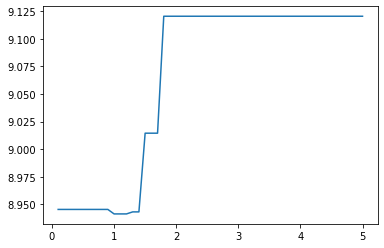

Zambia, count: 364


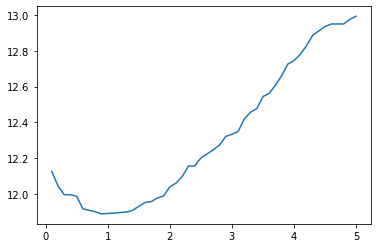

Djibouti, count: 364


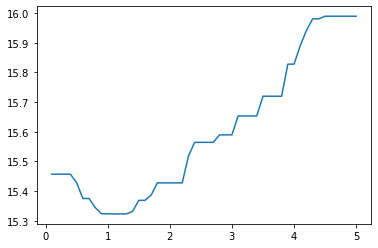

Kyrgyzstan, count: 364


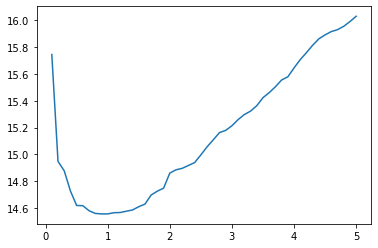

Montenegro, count: 365


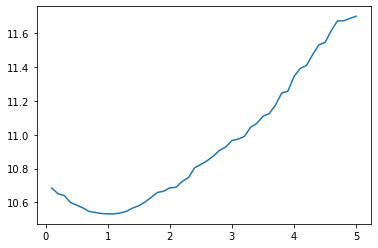

Barbados, count: 365


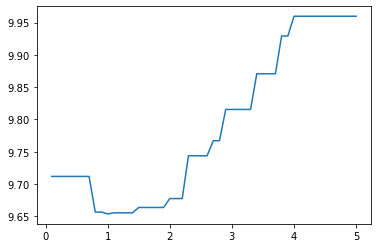

Benin, count: 366


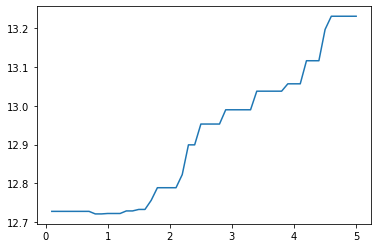

Somalia, count: 366


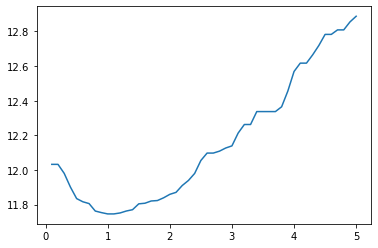

Liberia, count: 366


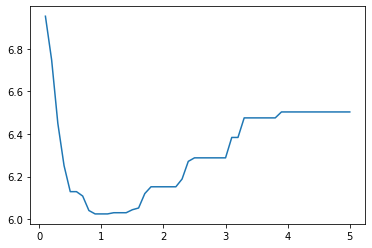

Tanzania, count: 366


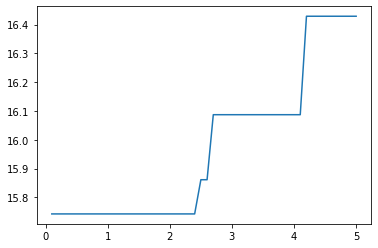

Equatorial Guinea, count: 367


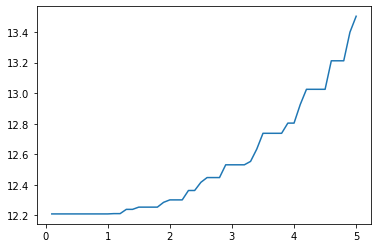

Congo (Brazzaville), count: 367


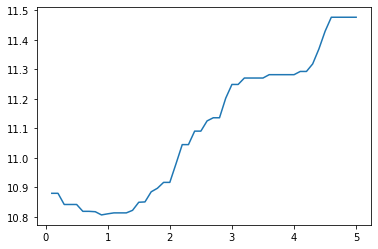

Uzbekistan, count: 367


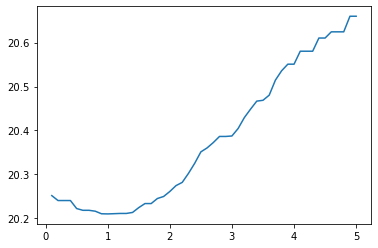

Central African Republic, count: 367


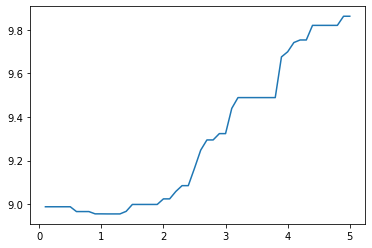

Guatemala, count: 368


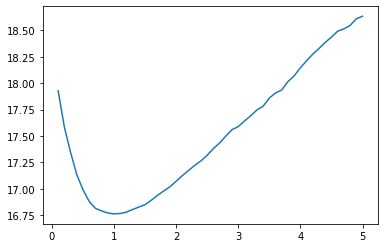

Trinidad and Tobago, count: 368


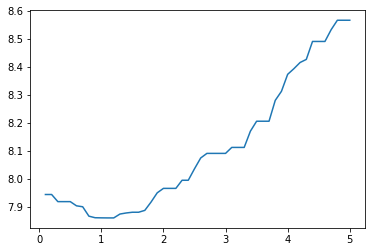

Saint Lucia, count: 368


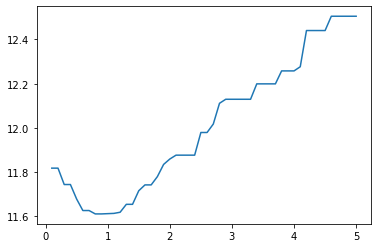

Suriname, count: 368


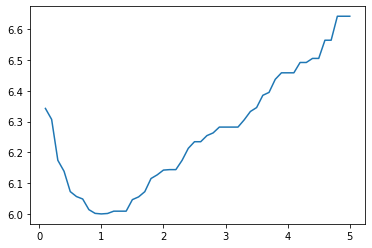

Mauritania, count: 368


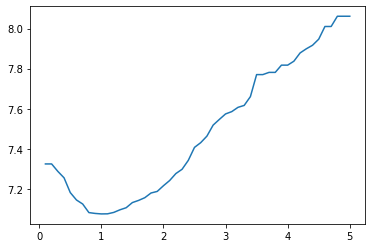

Namibia, count: 368


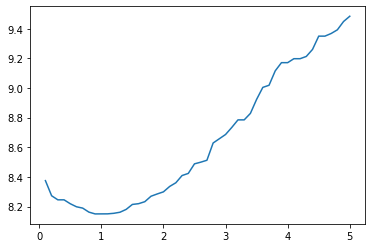

Seychelles, count: 368


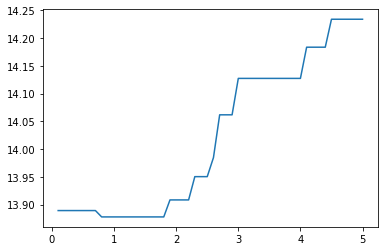

Ghana, count: 368


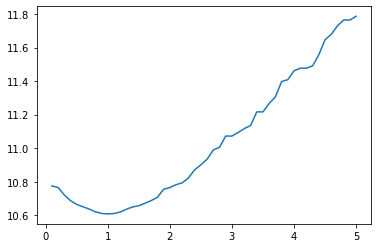

Rwanda, count: 368


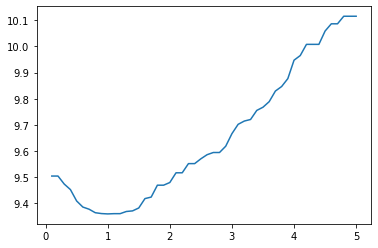

Gabon, count: 368


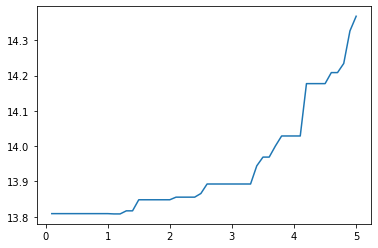

Saint Vincent and the Grenadines, count: 368


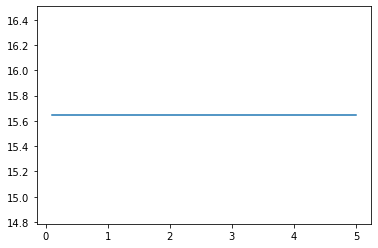

Uruguay, count: 368


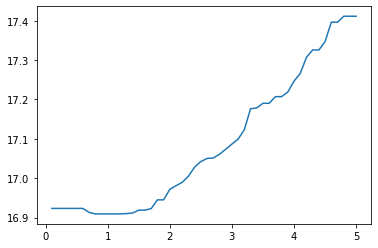

Venezuela, count: 368


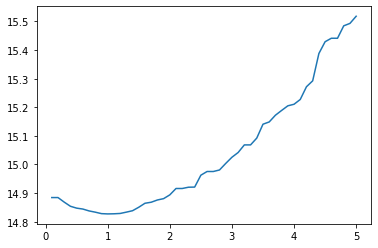

Eswatini, count: 368


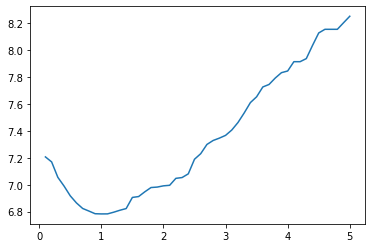

Ethiopia, count: 369


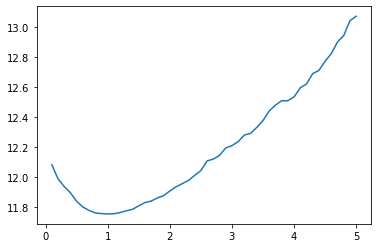

Antigua and Barbuda, count: 369


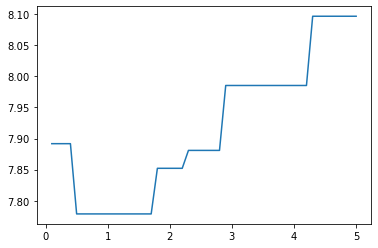

Kazakhstan, count: 369


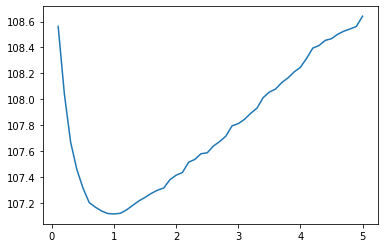

Guinea, count: 369


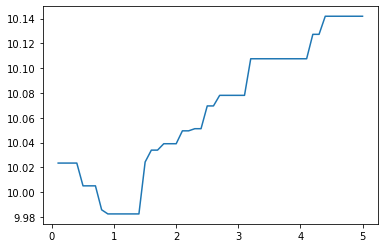

Sudan, count: 369


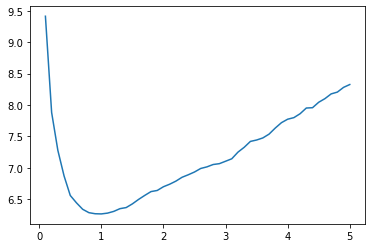

Kenya, count: 369


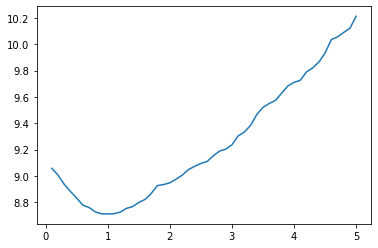

Cuba, count: 370


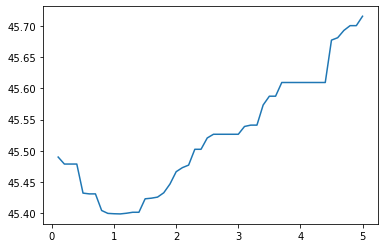

Guyana, count: 370


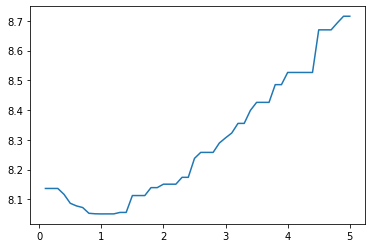

Cote d'Ivoire, count: 371


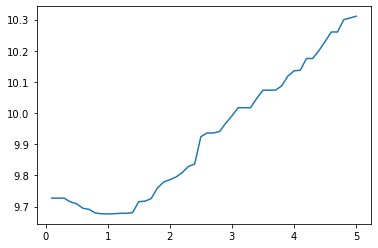

Taiwan*, count: 371


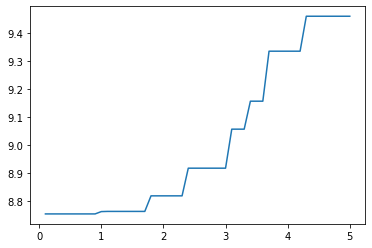

Czechia, count: 371


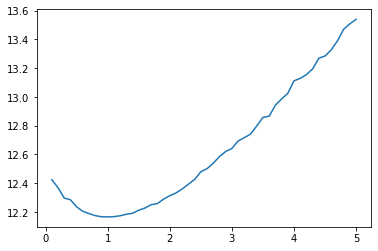

Korea, South, count: 371


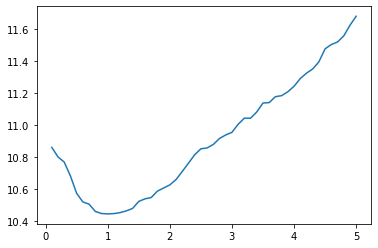

Bolivia, count: 371


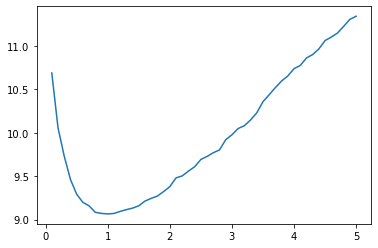

Jamaica, count: 371


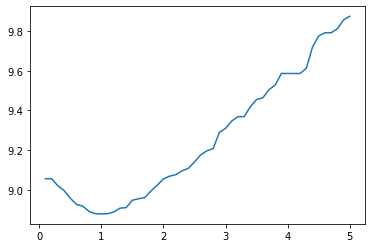

Honduras, count: 371


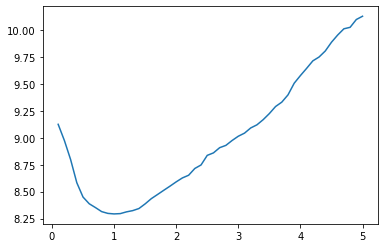

United Kingdom, count: 371


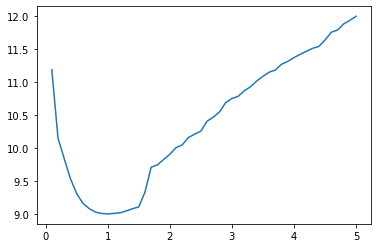

China, count: 371


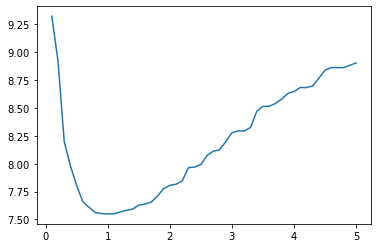

Turkey, count: 371


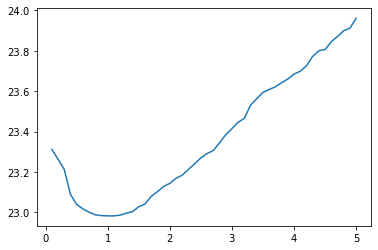

Congo (Kinshasa), count: 371


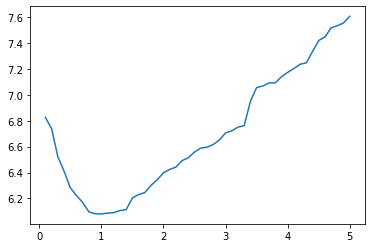

Mongolia, count: 372


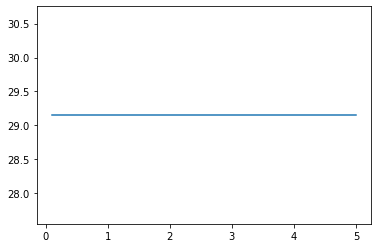

Burkina Faso, count: 372


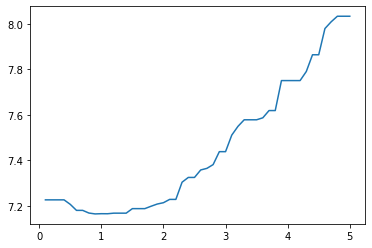

Panama, count: 372


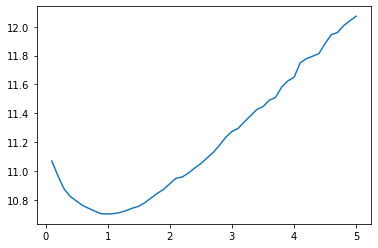

Albania, count: 373


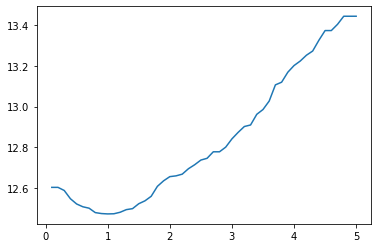

Moldova, count: 373


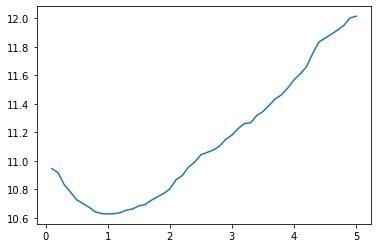

Brunei, count: 373


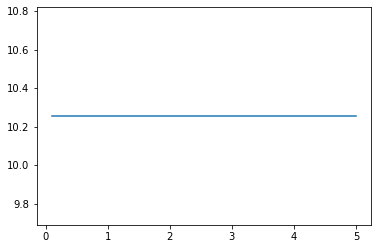

Cyprus, count: 373


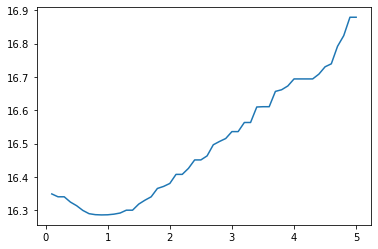

Bulgaria, count: 374


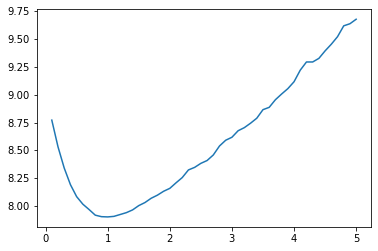

Paraguay, count: 374


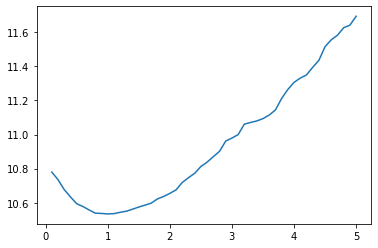

Bangladesh, count: 374


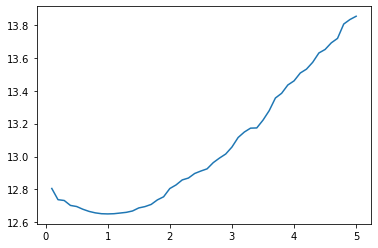

Maldives, count: 374


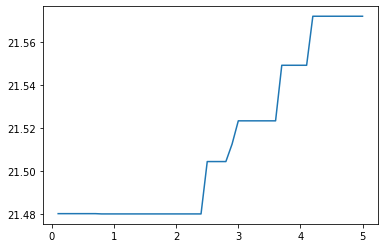

Malta, count: 375


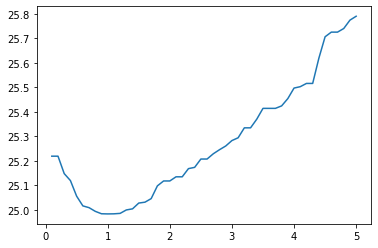

Bhutan, count: 376


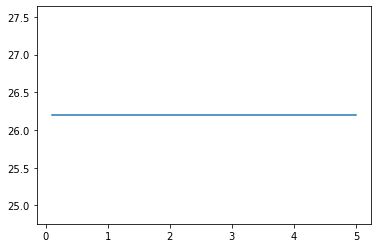

Slovakia, count: 376


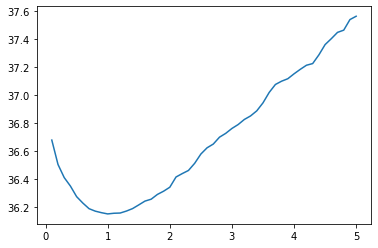

Serbia, count: 376


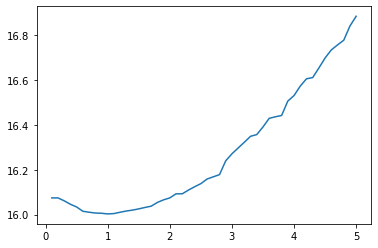

Togo, count: 376


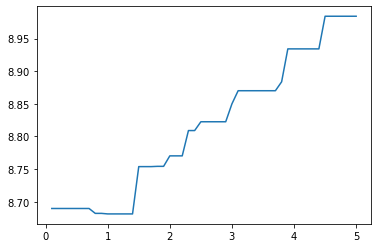

Costa Rica, count: 376


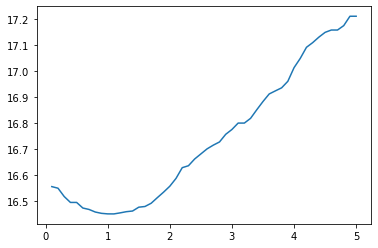

Peru, count: 376


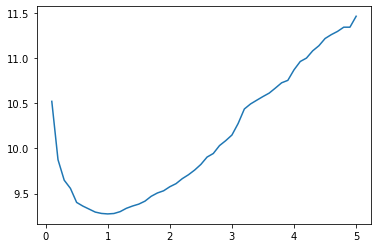

Cameroon, count: 376


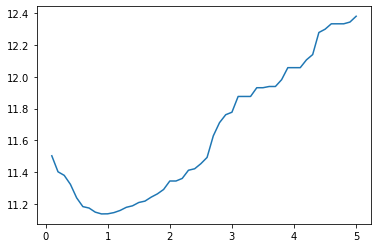

South Africa, count: 377


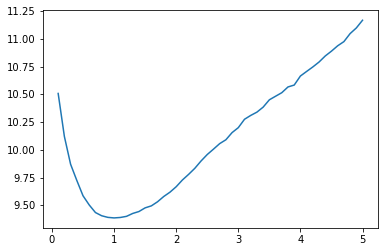

Bosnia and Herzegovina, count: 377


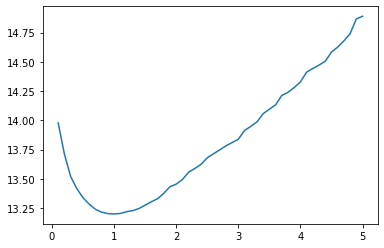

Slovenia, count: 377


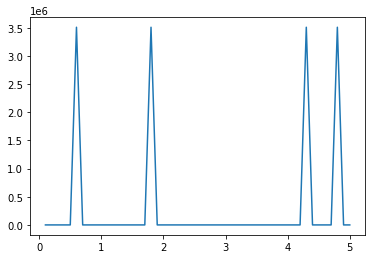

Colombia, count: 377


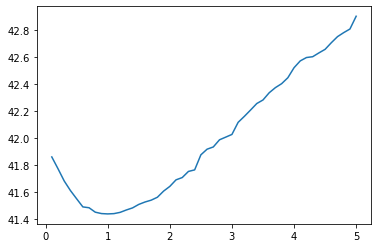

Tunisia, count: 378


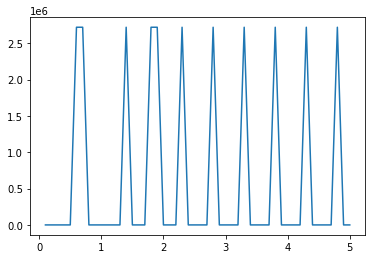

Poland, count: 378


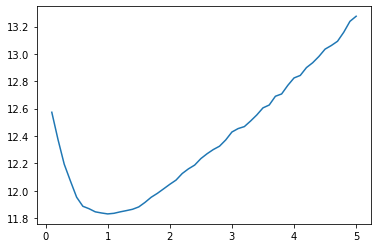

Hungary, count: 378


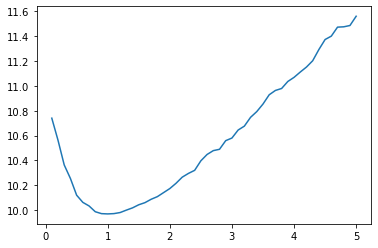

Liechtenstein, count: 378


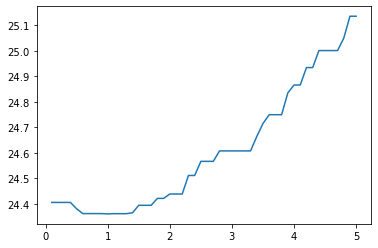

Chile, count: 379


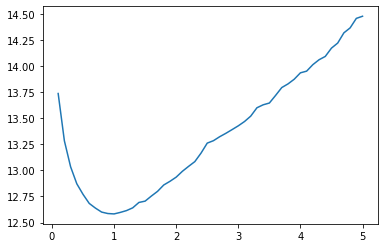

Jordan, count: 379


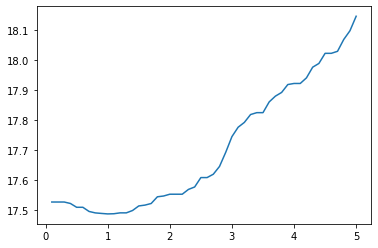

Argentina, count: 379


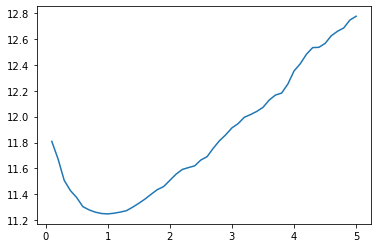

Ukraine, count: 379


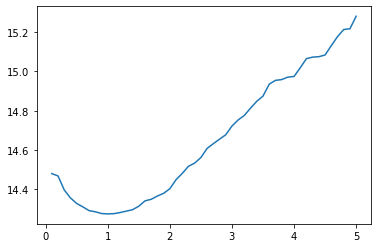

Portugal, count: 380


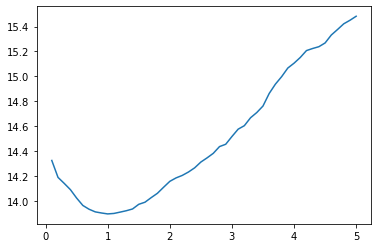

Saudi Arabia, count: 380


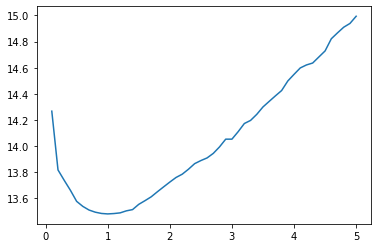

Senegal, count: 380


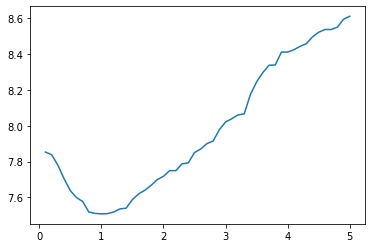

Morocco, count: 380


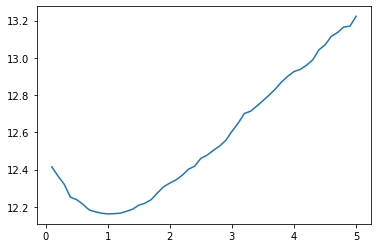

Indonesia, count: 380


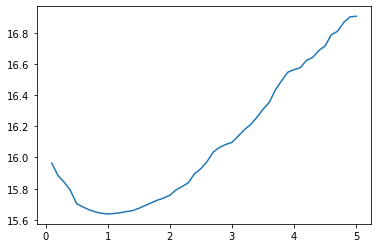

Andorra, count: 380


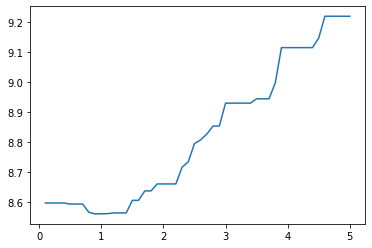

Latvia, count: 380


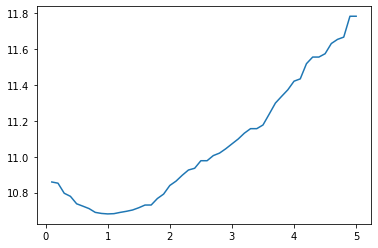

Armenia, count: 381


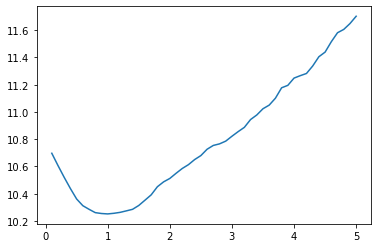

Ecuador, count: 381


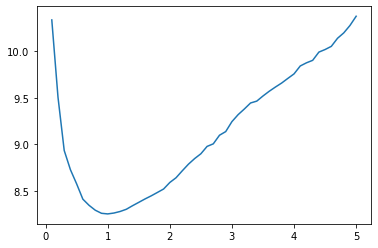

Dominican Republic, count: 381


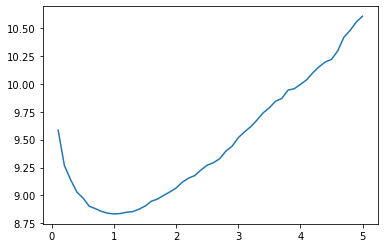

Azerbaijan, count: 381


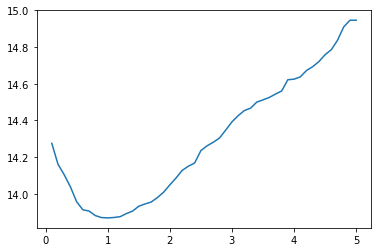

Luxembourg, count: 382


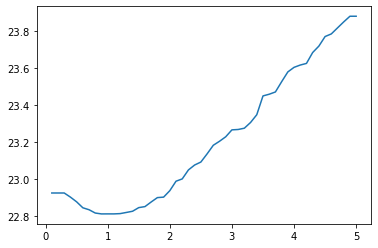

Ireland, count: 382


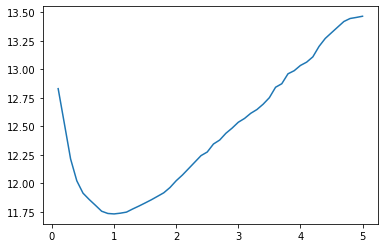

Monaco, count: 382


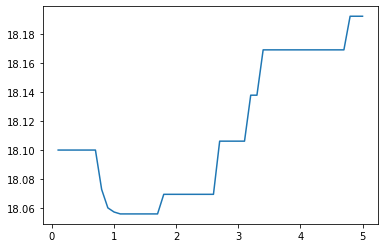

Qatar, count: 382


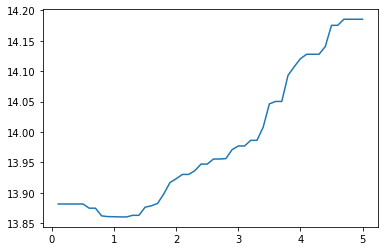

Belarus, count: 383


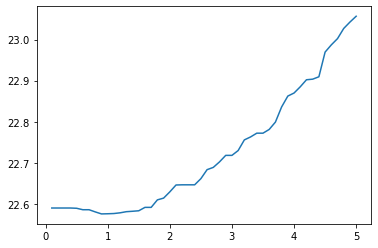

Lithuania, count: 383


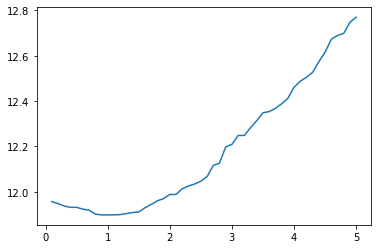

New Zealand, count: 383


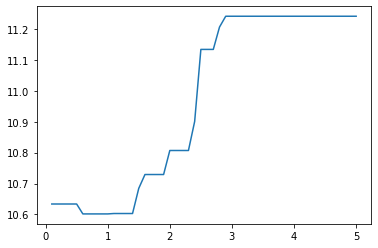

Iceland, count: 383


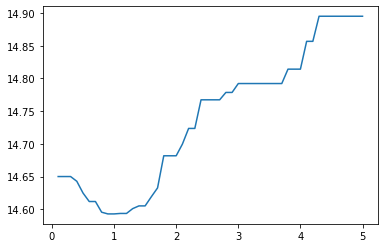

Nigeria, count: 383


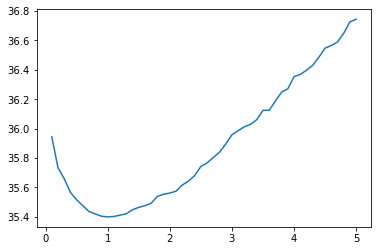

San Marino, count: 384


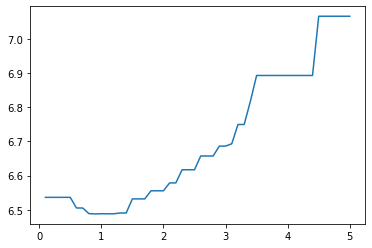

Denmark, count: 384


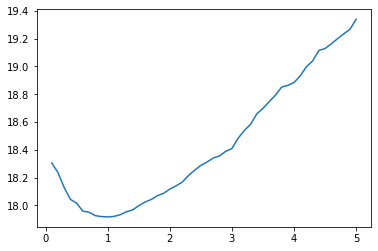

Estonia, count: 384


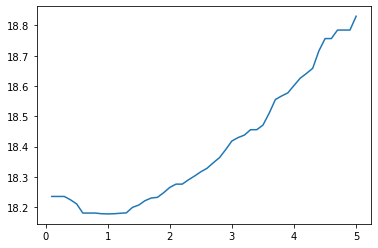

Netherlands, count: 384


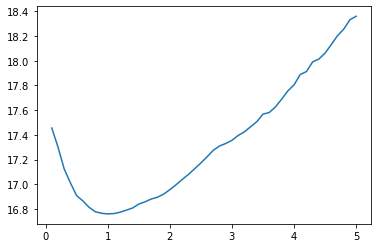

Mexico, count: 384


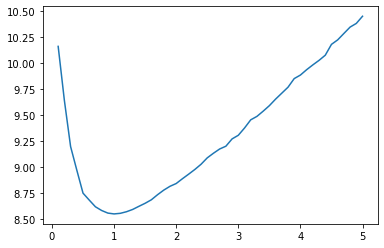

Romania, count: 385


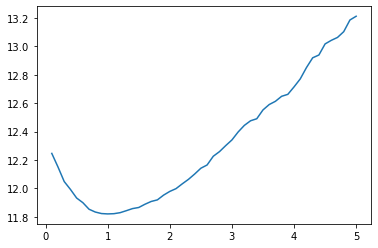

Pakistan, count: 385


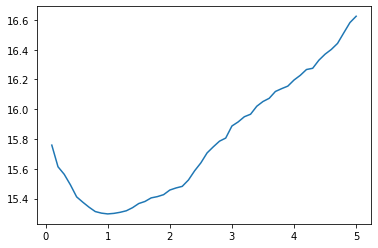

Norway, count: 385


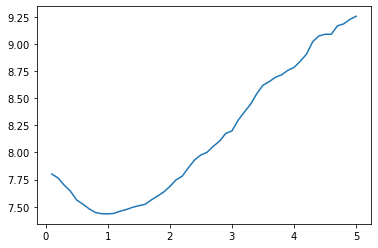

North Macedonia, count: 385


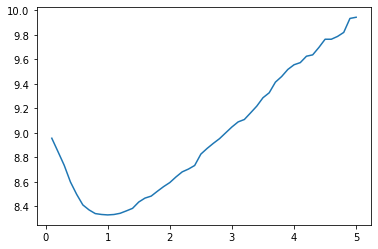

Georgia, count: 385


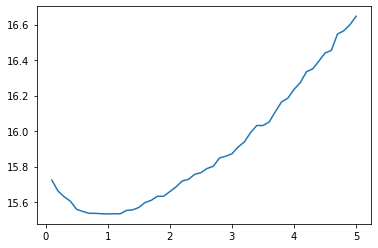

Greece, count: 385


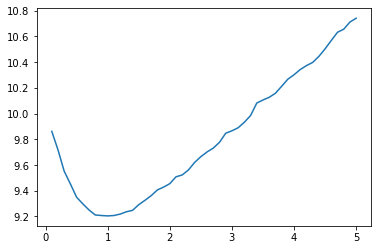

Algeria, count: 386


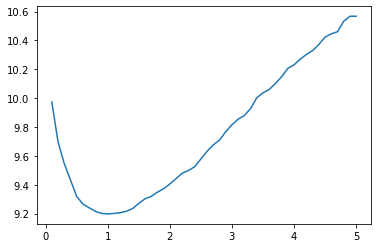

Croatia, count: 386


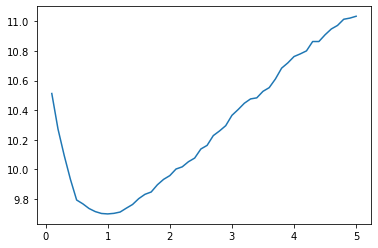

Switzerland, count: 386


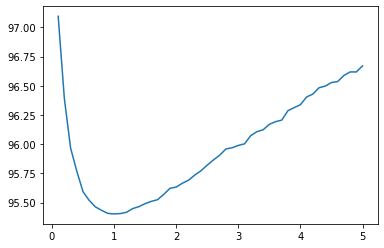

Brazil, count: 386


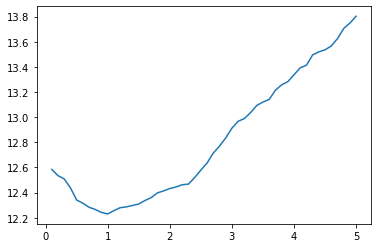

Austria, count: 386


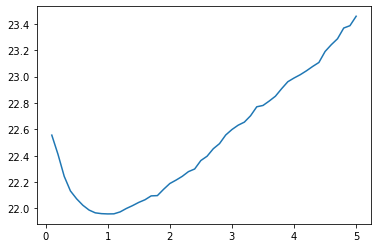

Kuwait, count: 387


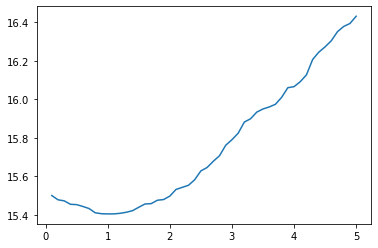

Afghanistan, count: 387


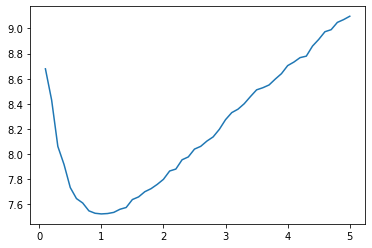

Oman, count: 387


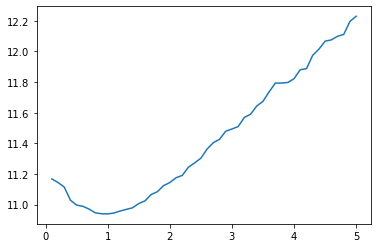

Bahrain, count: 387


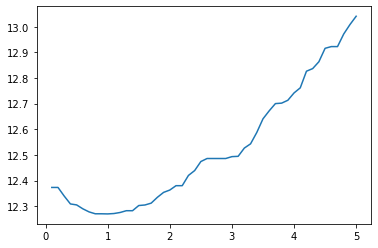

Iraq, count: 388


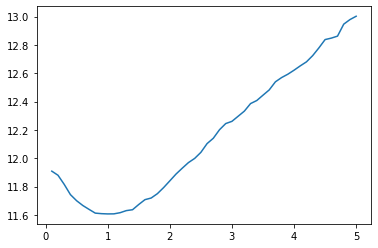

Lebanon, count: 390


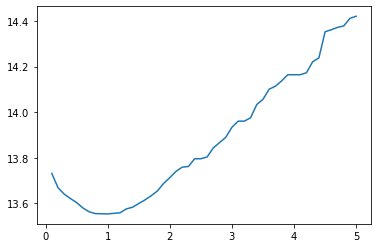

Israel, count: 390


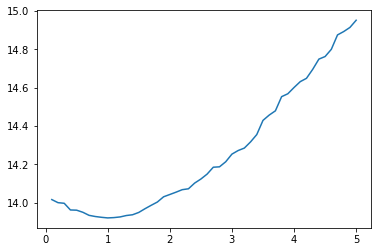

Iran, count: 391


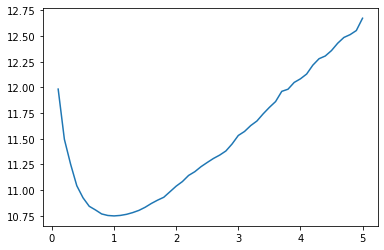

Egypt, count: 397


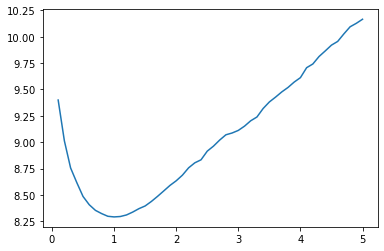

Belgium, count: 407


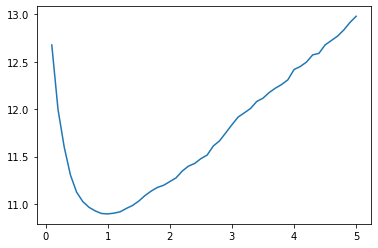

Spain, count: 410


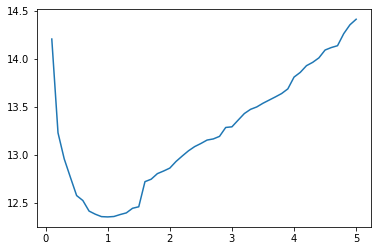

Russia, count: 410


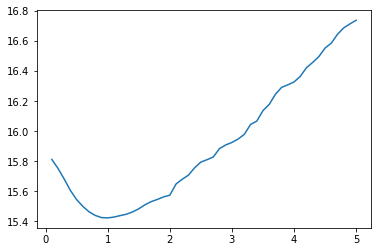

Sweden, count: 411


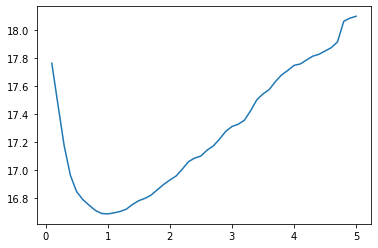

Italy, count: 411


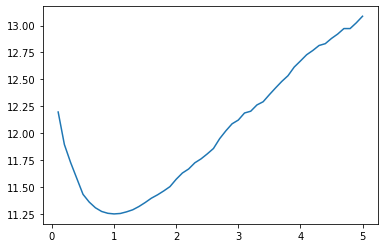

India, count: 412


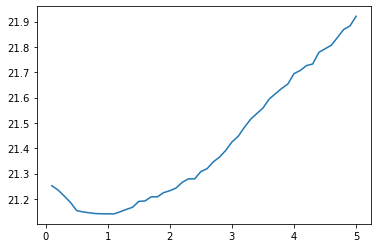

Finland, count: 413


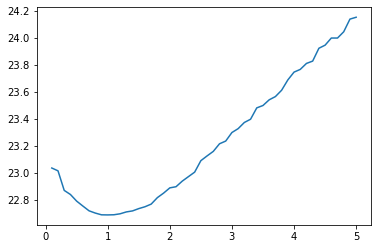

Philippines, count: 413


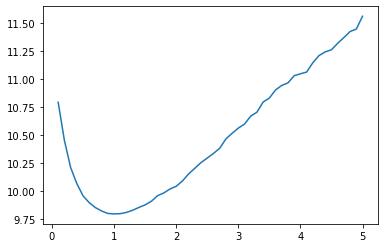

United Arab Emirates, count: 413


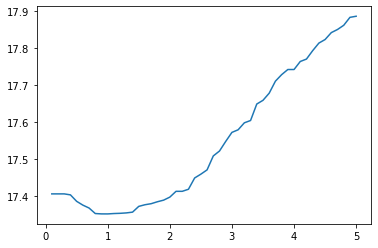

Germany, count: 414


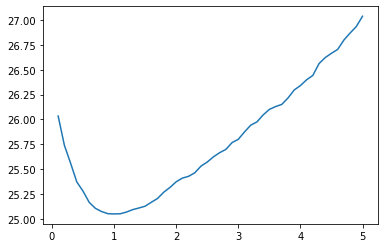

Sri Lanka, count: 415


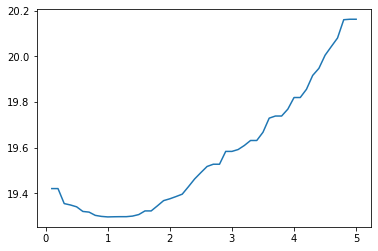

Cambodia, count: 415


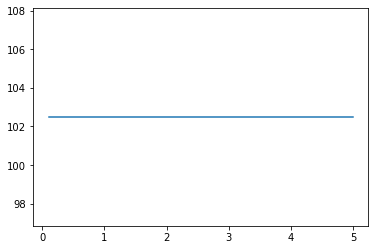

Canada, count: 416


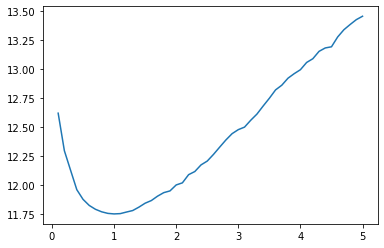

Nepal, count: 417


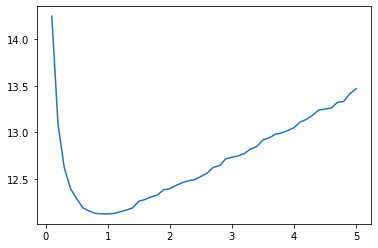

France, count: 418


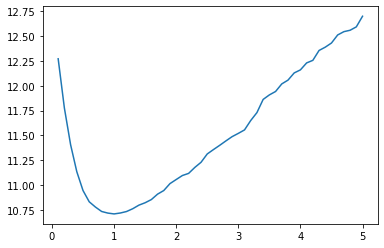

Australia, count: 418


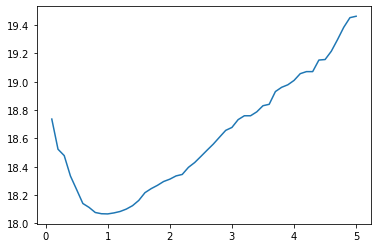

Vietnam, count: 418


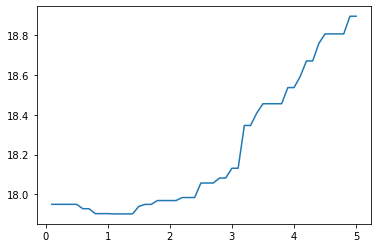

Malaysia, count: 418


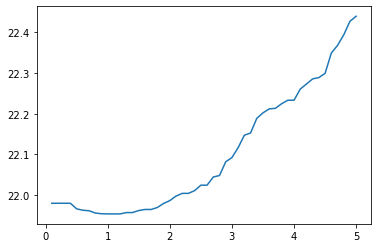

Singapore, count: 419


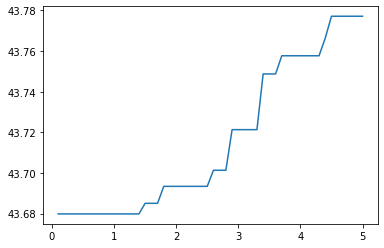

Thailand, count: 420


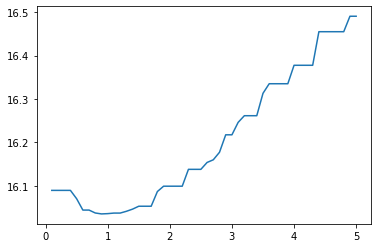

Japan, count: 420


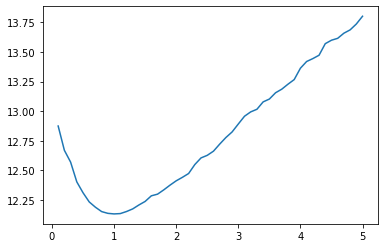

US, count: 420


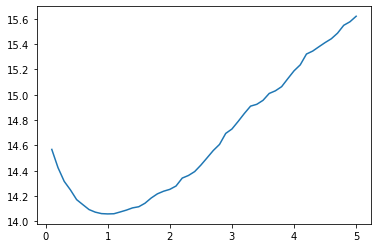

In [8]:
sff2.sort_values(by=['datacount'], inplace=True)
for index, row in sff2.iterrows():
    print (row['Contry'] + ", count: " + str(row['datacount']))
    plt.plot(ss,row['LMUC'])
    plt.show()

In [78]:
fig = px.scatter(x=sff2['scale_f'],y=sff2['datacount'],hover_name=sff2['Contry'],
    labels=dict(x="scale_f", y="datacount"))
fig.update_layout(title = "Javasolt skálázási értékek a mintaszám fényében")
fig.show()

In [93]:
choosen2 = 'Equatorial Guinea'
acontd2 = covidbycont[choosen2].copy()

In [94]:
scal = sff[sff['Contry'] == choosen2].iloc[0,0]
print(scal)

xmax = acontd2['Conf'].max()
ymax = acontd2['Death'].max()

fig1 = px.scatter(x=acontd2['Conf'],y=acontd2['Death'],
                 hover_name=acontd2['Date'], color=acontd2['int_date'], 
                 color_continuous_scale=px.colors.sequential.Viridis)
fig1.update_layout(
    title = choosen2+" - 1x1"
)
fig1.update_xaxes(range=[-xmax*0.05,xmax*1.05], constrain="domain")
fig1.update_yaxes(range=[-ymax*0.05,ymax*1.05], scaleanchor = "x", scaleratio = xmax/ymax, constrain="domain")

fig2 = px.scatter(x=acontd2['Conf'],y=acontd2['Death'],
                 hover_name=acontd2['Date'], color=acontd2['int_date'], 
                 color_continuous_scale=px.colors.sequential.Viridis)
fig2.update_layout(
    title = choosen2+" - scale: "+str(scal)
)
fig2.update_xaxes(range=[-xmax*0.05,xmax*1.05], constrain="domain")
fig2.update_yaxes(range=[-ymax*0.05,ymax*1.05], scaleanchor = "x", scaleratio = scal*xmax/ymax, constrain="domain")

fig1.show()
fig2.show()

0.1
